In [30]:
import pandas as pd
from sklearn.mixture import GaussianMixture # for GMM clustering
from sklearn import metrics # for calculating Silhouette score

import matplotlib.pyplot as plt # for data visualization
import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization
from sklearn.cluster import KMeans
import pandas as pd
import plotly
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import timeit
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
import warnings
warnings.filterwarnings(action='once')
import seaborn as sns

/Users/ej7793/opt/anaconda3/lib/python3.7/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/ej7793/.local/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


# Flight Delay data problem 

## Clustering 

In [6]:
FD_df = pd.read_csv('../Data/FD_Feature_engineered.csv')

In [7]:
FD_df = FD_df.sample(10000)

X_train, X_final_test = train_test_split(FD_df,test_size=0.2, random_state= 2)
X_final_test.to_csv('../Data/testing_dataset.csv', index = False)
## within the training dataset, split the data into training dataset and testing/validation dataset
X_train, X_test = train_test_split(X_train,test_size=0.2, random_state= 2)
print('records in training dataset')
print(len(X_train))
print('records in validation dataset')
print(len(X_test))
print('records in final testing dataset')
print(len(X_final_test))

records in training dataset
6400
records in validation dataset
1600
records in final testing dataset
2000


In [9]:
X_train.columns

Index(['Saturday', 'Tuesday_Wednesday', 'CARRIER_rank', 'ORIGIN_rank',
       'DEST_rank', 'LATE_NIGHT', 'DEP_HOUR_rank', 'DEP_DEL15', 'ARR_DEL15'],
      dtype='object')

### GMM 

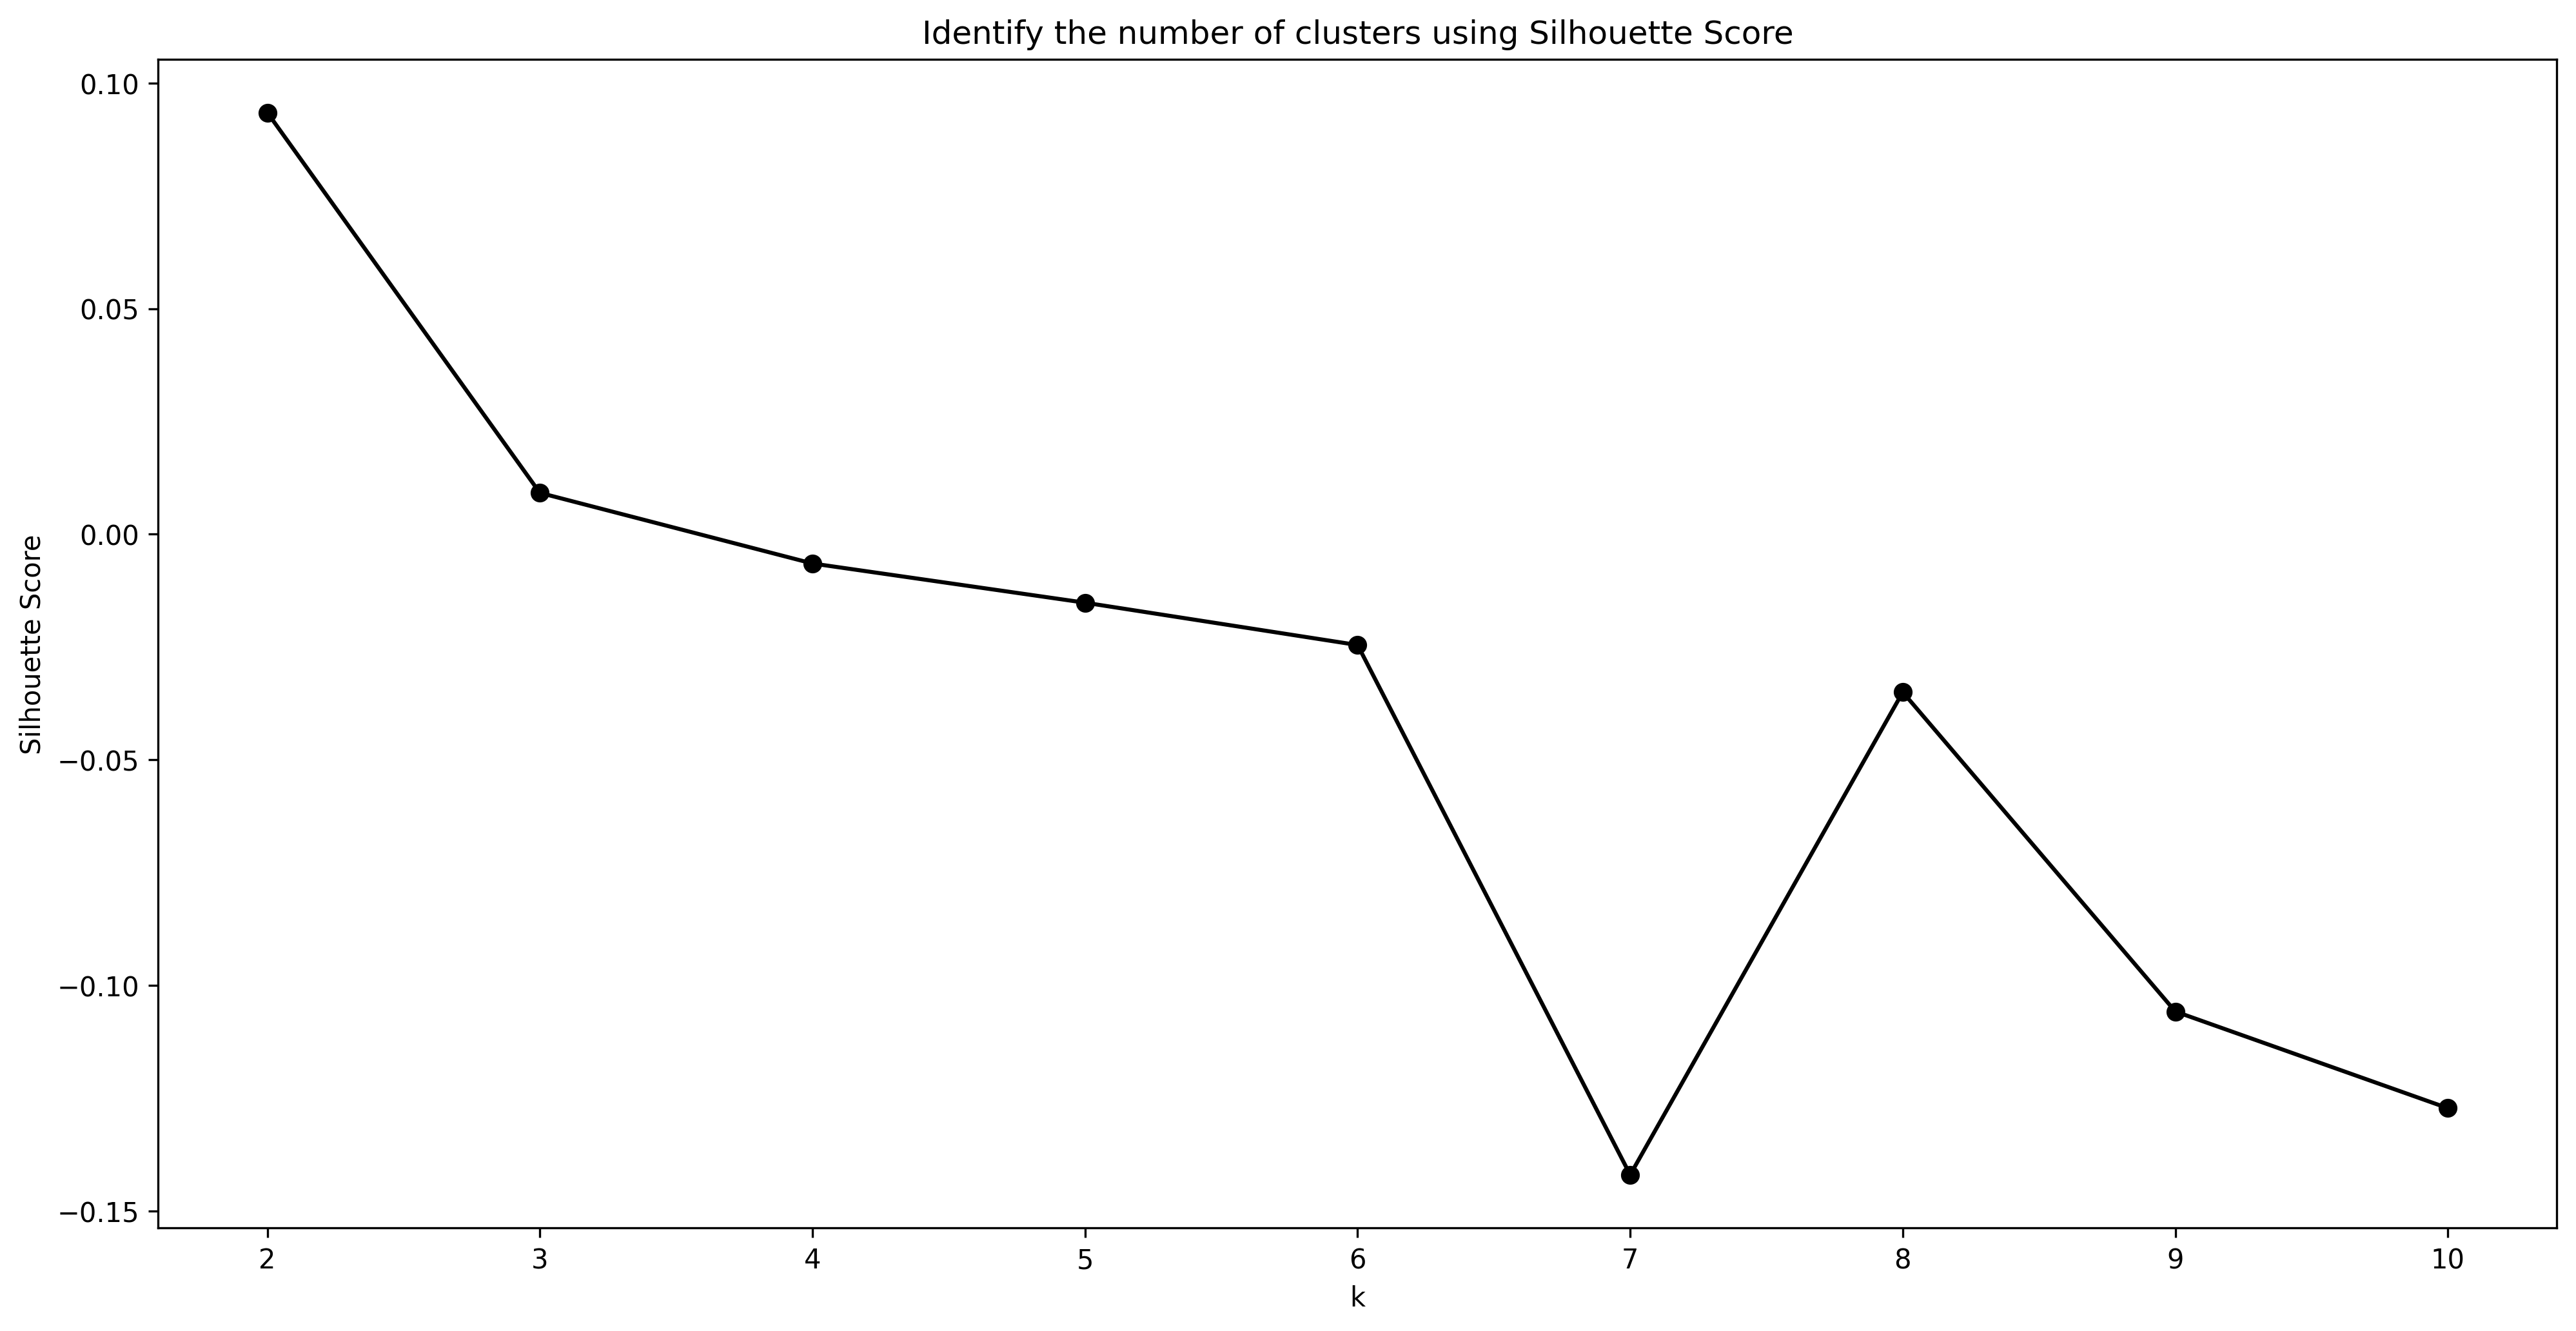

The Silhouette score is used to measure the degree of separation and the within cluster density. based on the graph, we are seeing that when cluster number is 2, we have the highest silhouette score.


In [10]:
# Create empty list
S=[]

# Range of clusters to try (2 to 10)
K=range(2,11)

# Select data for clustering model

X = X_train.drop(['ARR_DEL15'], axis = 1)

for k in K:
    # Set the model and its parameters
    model = GaussianMixture(n_components=k, n_init=20, init_params='kmeans')
    # Fit the model 
    labels = model.fit_predict(X)
    # Calculate Silhoutte Score and append to a list
    S.append(metrics.silhouette_score(X, labels, metric='euclidean'))

# Plot the resulting Silhouette scores on a graph
plt.figure(figsize=(16,8), dpi=300)
plt.plot(K, S, 'bo-', color='black')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Identify the number of clusters using Silhouette Score')
plt.show()
print('The Silhouette score is used to measure the degree of separation and the within cluster density. based on the graph, we are seeing that when cluster number is 2, we have the highest silhouette score.')


In [11]:
GMM_model = GaussianMixture(n_components=2, # this is the number of clusters
                         covariance_type='full', # {‘full’, ‘tied’, ‘diag’, ‘spherical’}, default=’full’
                         max_iter=100, # the number of EM iterations to perform. default=100
                         n_init=20, # the number of initializations to perform. default = 1
                         init_params='kmeans', # the method used to initialize the weights, the means and the precisions. {'random' or default='k-means'}
                         verbose=0, # default 0, {0,1,2}
                         random_state=1 # for reproducibility
                        )

**Distance between GMMs**

Here we form two datasets, each with an half randomly choose amount of data. We will then check how much the GMMs trained on the two sets are similar, for each configuration.

Since we are talking about distributions, the concept of similarity is embedded in the Jensen-Shannon (JS) metric. The lesser is the JS-distance between the two GMMs, the more the GMMs agree on how to fit the data.

The lower the distance, the better the cluster.

In [12]:
#Courtesy of https://stackoverflow.com/questions/26079881/kl-divergence-of-two-gmms. Here the difference is that we take the squared root, so it's a proper metric
## reference: kaggle notebook https://www.kaggle.com/code/vipulgandhi/gaussian-mixture-models-clustering-explained/notebook
def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

In [13]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [14]:
n_clusters=np.arange(2, 11)
iterations=20
results=[]
res_sigs=[]



for n in n_clusters:
    dist=[]
    
    for iteration in range(iterations):
        train, test=train_test_split(X, test_size=0.5)
        gmm_train=GaussianMixture(n, n_init=20).fit(train) 
        gmm_test=GaussianMixture(n, n_init=20).fit(test) 
        dist.append(gmm_js(gmm_train, gmm_test))
    selec=SelBest(np.array(dist), int(iterations/5))
    result=np.mean(selec)
    res_sig=np.std(selec)
    results.append(result)
    res_sigs.append(res_sig)

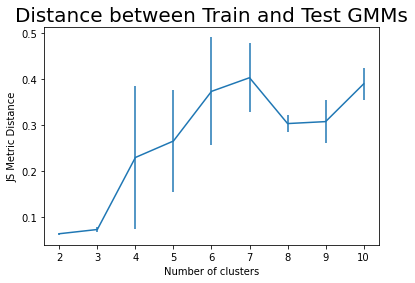

In [15]:
plt.errorbar(n_clusters, results, yerr=res_sigs)
plt.title("Distance between Train and Test GMMs", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("Number of clusters")
plt.ylabel("JS Metric Distance")
plt.show()

### K means

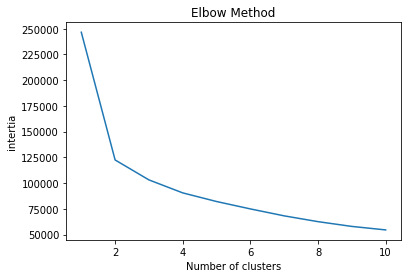

In [19]:
##Elbow method 

# Select data for clustering model and restrict to predictors only 
X = X_train.drop(['ARR_DEL15'], axis = 1)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('intertia')
plt.show()

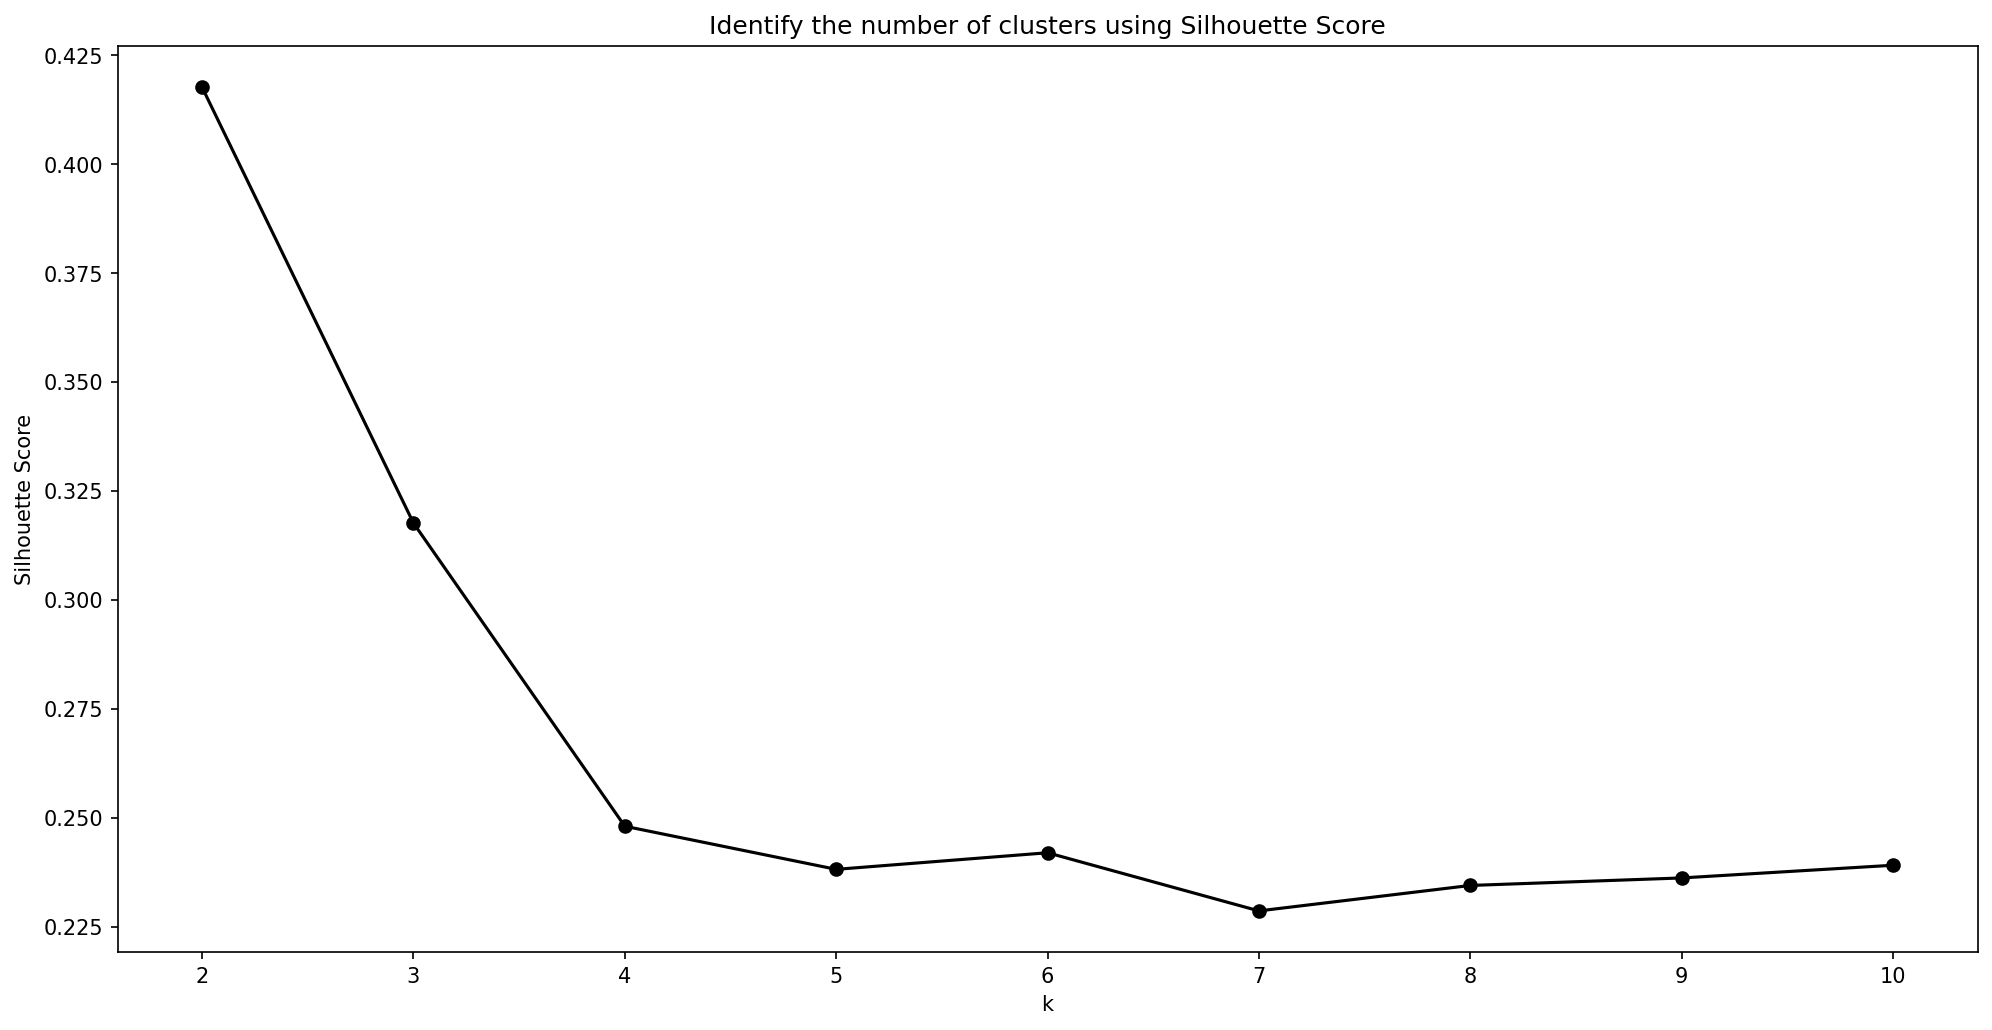

Choose to have 2 clusters due to highest silhouette score
the silhouette score for 2 clusters is 0.418


In [25]:
S=[]

# Range of clusters to try (2 to 10)
K=range(2,11)

for k in K:
    # Set the model and its parameters
    model = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    # Fit the model 
    labels = model.fit_predict(X)
    # Calculate Silhoutte Score and append to a list
    S.append(metrics.silhouette_score(X, labels, metric='euclidean'))

# Plot the resulting Silhouette scores on a graph
plt.figure(figsize=(16,8), dpi=150)
plt.plot(K, S, 'bo-', color='black')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Identify the number of clusters using Silhouette Score')
plt.show()
print('Choose to have 2 clusters due to highest silhouette score')
print('the silhouette score for 2 clusters is %.3f' % S[0])

In [26]:
max(S)

0.4176826161100033

## Clustering Results Evaluation 

### GMM

In [27]:
GMM_model = GaussianMixture(n_components=2, # this is the number of clusters
                         covariance_type='full', # {‘full’, ‘tied’, ‘diag’, ‘spherical’}, default=’full’
                         max_iter=100, # the number of EM iterations to perform. default=100
                         n_init=20, # the number of initializations to perform. default = 1
                         init_params='kmeans', # the method used to initialize the weights, the means and the precisions. {'random' or default='k-means'}
                         verbose=0, # default 0, {0,1,2}
                         random_state=1 # for reproducibility
                        )
y_pred = GMM_model.fit_predict(X)

In [28]:
X_GMM = X_train
X_GMM['cluster'] = y_pred

/Users/ej7793/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):


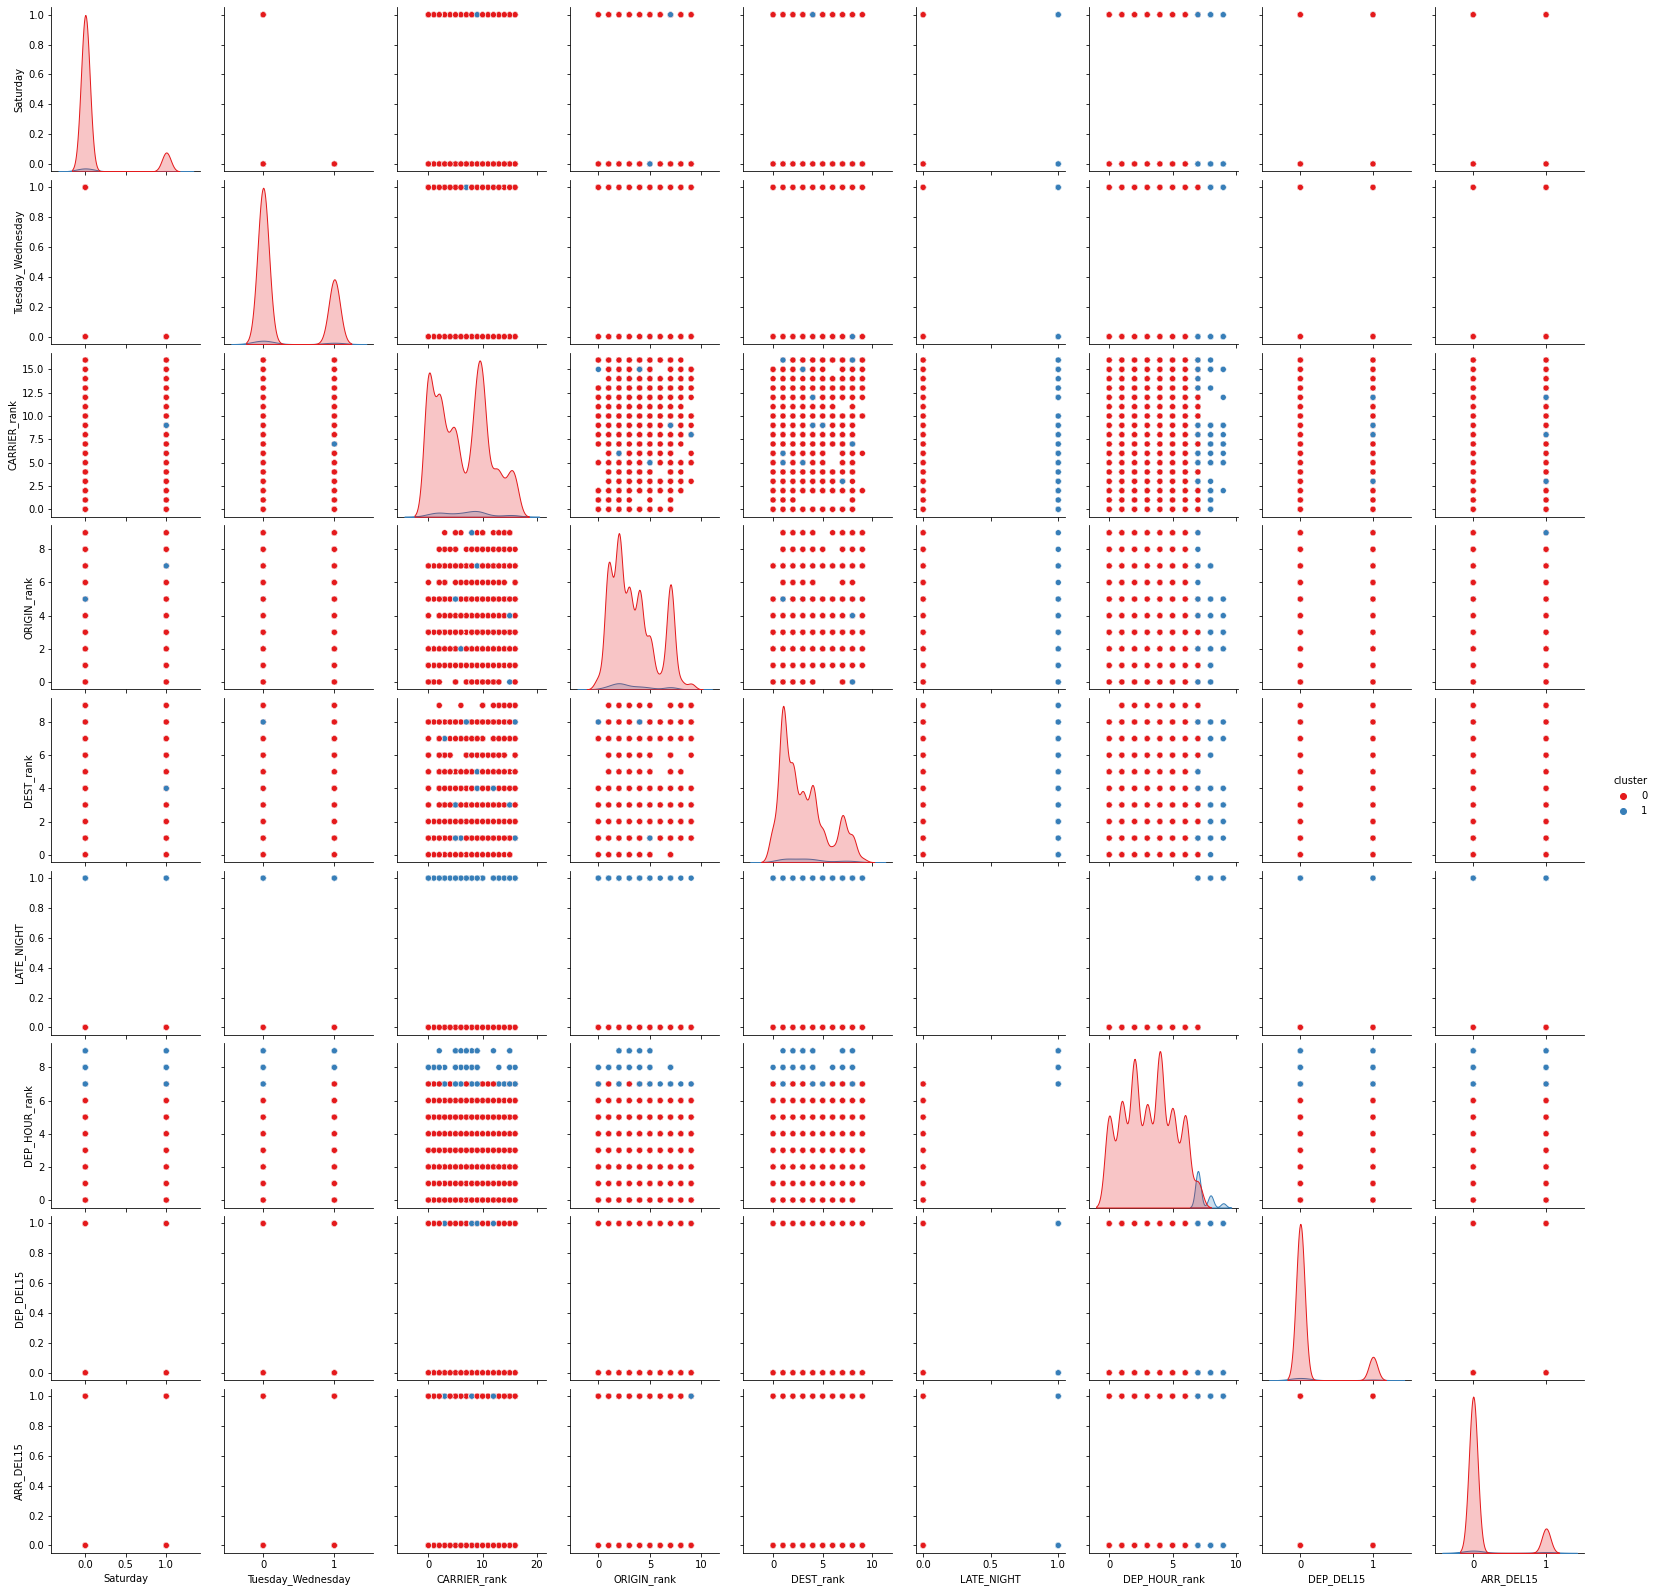

In [33]:
sns.pairplot(data=X_GMM, hue="cluster", palette = 'Set1')

In [34]:
X_GMM['cluster'].value_counts(normalize = True)

/Users/ej7793/opt/anaconda3/lib/python3.7/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/Users/ej7793/opt/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:99: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(version) < minimum_version:
/Users/ej7793/.local/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


0    0.96125
1    0.03875
Name: cluster, dtype: float64

In [36]:
X_GMM.groupby(['DEP_DEL15'])['cluster'].value_counts(normalize = True)

DEP_DEL15  cluster
0.0        0          0.966227
           1          0.033773
1.0        0          0.929316
           1          0.070684
Name: cluster, dtype: float64

### K Means

In [37]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
y_pred = kmeans.predict(X)

In [38]:
X_k_means = X_train
X_k_means['cluster'] = y_pred

/Users/ej7793/opt/anaconda3/lib/python3.7/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/ej7793/.local/lib/python3.7/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


/Users/ej7793/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):


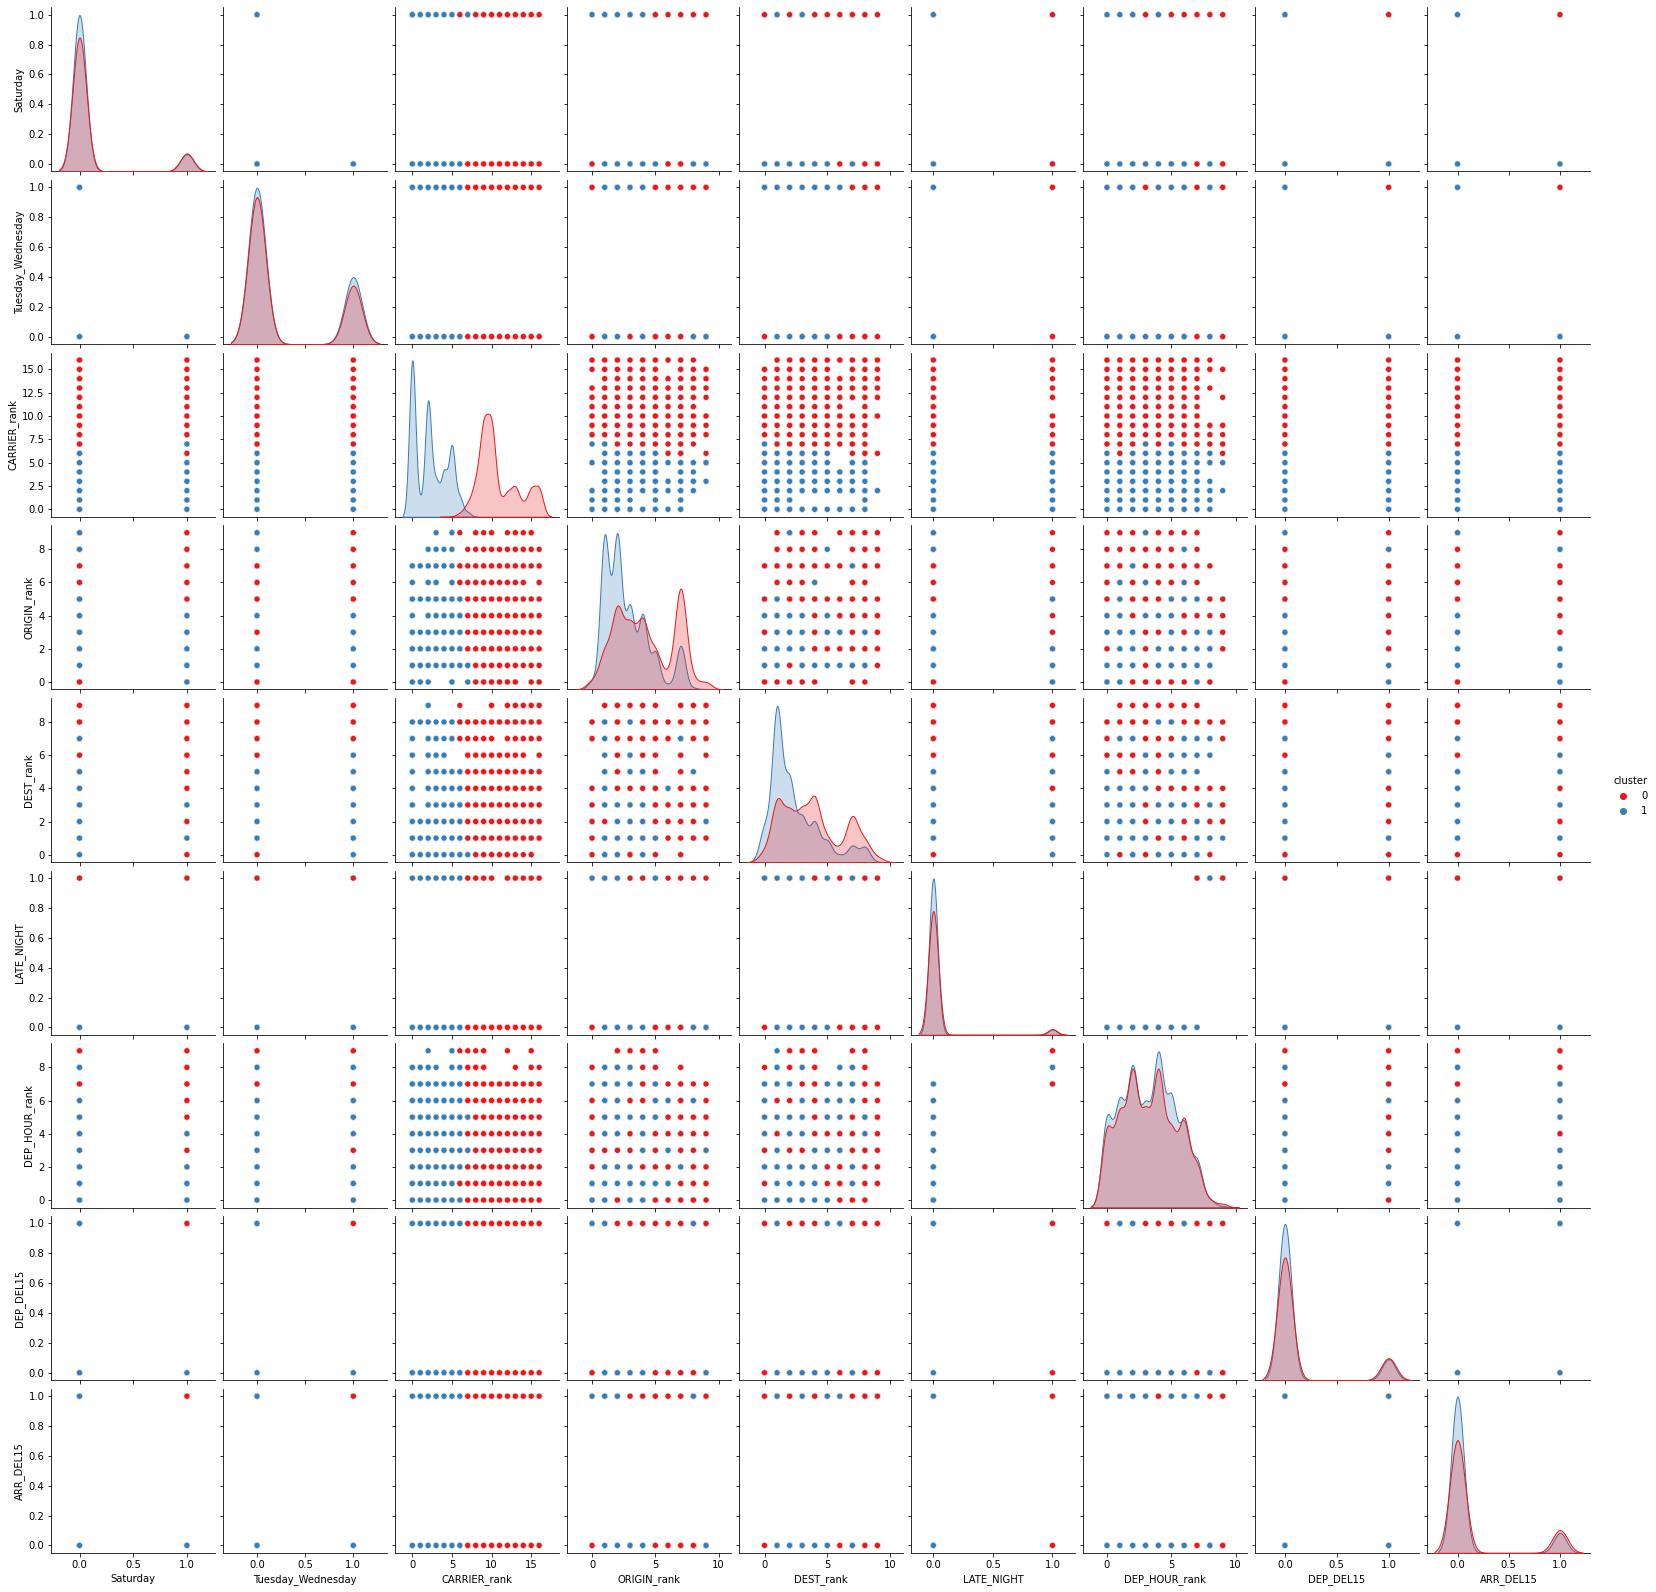

In [39]:
sns.pairplot(data=X_k_means, hue="cluster", palette = 'Set1')

In [40]:
X_k_means['cluster'].value_counts(normalize = True)

1    0.520625
0    0.479375
Name: cluster, dtype: float64

In [41]:
X_k_means.groupby(['DEP_DEL15'])['cluster'].value_counts(normalize = True)

DEP_DEL15  cluster
0.0        1          0.530251
           0          0.469749
1.0        0          0.541136
           1          0.458864
Name: cluster, dtype: float64